<a href="https://colab.research.google.com/github/fjadidi2001/AD_Prediction/blob/main/LdiNet_Denoised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Novel Approach to Noise Reduction in Images Utilizing a Decomposition Technique

Using device: cuda


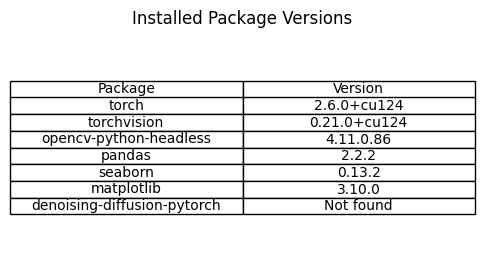

--2025-05-21 19:05:20--  https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
Resolving www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)... 128.32.244.190
Connecting to www2.eecs.berkeley.edu (www2.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70763455 (67M) [application/x-tar]
Saving to: ‘BSR_bsds500.tgz’

BSR_bsds500.tgz     100%[===================>]  67.48M  66.1MB/s    in 1.0s    

2025-05-21 19:05:21 (66.1 MB/s) - ‘BSR_bsds500.tgz’ saved [70763455/70763455]

Dataset loaded successfully


In [3]:
# Cell 1: Install Dependencies (Fixed)
# Install required packages with specific versions to avoid conflicts
!pip install nvidia-nvjitlink-cu12==12.4.127
!pip install torch torchvision torchaudio
!pip install opencv-python-headless
!pip install pandas seaborn matplotlib
!pip install scikit-image
!pip install denoising-diffusion-pytorch

# Cell 2: Import Libraries and Setup Environment
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
try:
    from denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer
except ImportError:
    print("Note: denoising-diffusion-pytorch import failed, but we can continue without it")

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Cell 3: Visualize Package Versions (Fixed)
import pkg_resources
packages = ['torch', 'torchvision', 'opencv-python-headless', 'pandas', 'seaborn', 'matplotlib']
try:
    packages.append('denoising-diffusion-pytorch')
except:
    pass

versions = {}
for pkg in packages:
    try:
        versions[pkg] = pkg_resources.get_distribution(pkg).version
    except:
        versions[pkg] = "Not found"

df_versions = pd.DataFrame(list(versions.items()), columns=['Package', 'Version'])

plt.figure(figsize=(6, 3))
plt.table(cellText=df_versions.values, colLabels=df_versions.columns, loc='center', cellLoc='center')
plt.axis('off')
plt.title("Installed Package Versions")
plt.savefig('package_versions.png')
plt.show()

# Cell 4: Download and Extract BSR Dataset
try:
    if not os.path.exists('BSR_bsds500.tgz'):
        !wget https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
    if not os.path.exists('BSR'):
        !tar xzf BSR_bsds500.tgz
    print("Dataset loaded successfully")
except Exception as e:
    print(f"Error loading dataset: {e}")
    # Create a fallback directory if download fails
    if not os.path.exists('BSR/BSDS500/data/images/train'):
        os.makedirs('BSR/BSDS500/data/images/train', exist_ok=True)
        print("Created fallback directory structure")



In [4]:
# Cell 5: Create Custom Dataset Class
import glob
from torch.utils.data import Dataset

class BSRDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = glob.glob(os.path.join(root_dir, '*.jpg'))
        # Fallback if no images found
        if len(self.image_paths) == 0:
            print(f"No images found in {root_dir}. Creating dummy data.")
            # Create a small dummy image for testing
            dummy_img = Image.new('L', (128, 128), color=128)
            dummy_path = os.path.join(root_dir, 'dummy.jpg')
            dummy_img.save(dummy_path)
            self.image_paths = [dummy_path]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Grayscale
        if self.transform:
            image = self.transform(image)
        return image, 0  # Dummy label


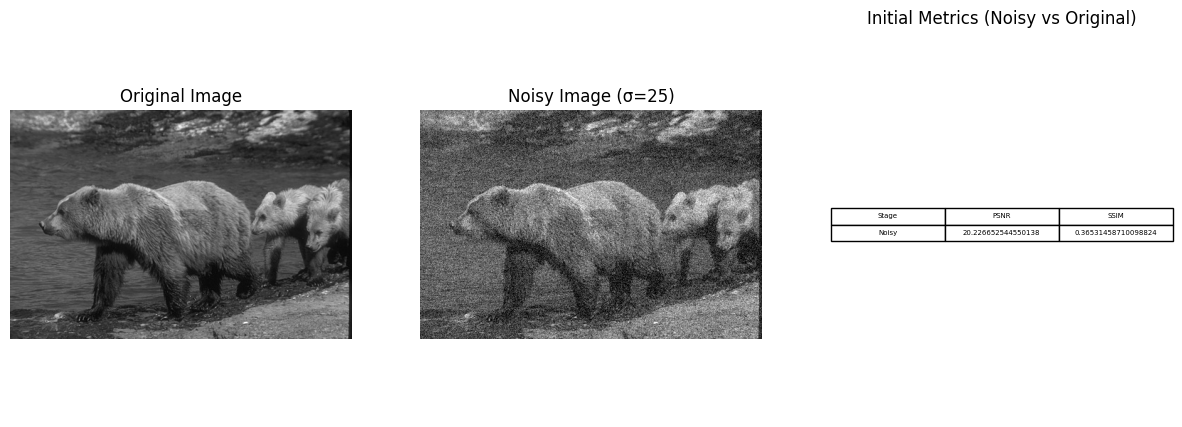

Starting training for 5 epochs
Epoch 1/5, Loss: 0.0152
Epoch 2/5, Loss: 0.0057
Epoch 3/5, Loss: 0.0053
Epoch 4/5, Loss: 0.0054
Epoch 5/5, Loss: 0.0041


In [6]:
# Cell 6: Define Transforms and Create DataLoader
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load BSR dataset (train folder)
bsr_train_path = 'BSR/BSDS500/data/images/train'
dataset = BSRDataset(bsr_train_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Cell 7: Prepare Sample Image for Visualization
# Load a sample image or create a dummy one if needed
try:
    image_path = 'BSR/BSDS500/data/images/train/100075.jpg'
    original_image = Image.open(image_path).convert('L')
except:
    print("Sample image not found, creating dummy image")
    original_image = Image.new('L', (128, 128), color=128)

np_image = np.array(original_image)

# Add Gaussian noise
sigma = 25
noisy_image = np_image + np.random.normal(0, sigma, np_image.shape)
noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
noisy_image_pil = Image.fromarray(noisy_image)

# Convert to tensor
noisy_tensor = transform(noisy_image_pil).to(device)

# Cell 8: Compute Initial Metrics
psnr_noisy = psnr(np_image, noisy_image, data_range=255)
ssim_noisy = ssim(np_image, noisy_image, data_range=255)
metrics = pd.DataFrame({
    'Stage': ['Noisy'],
    'PSNR': [psnr_noisy],
    'SSIM': [ssim_noisy]
})

# Visualization: Original, Noisy, and Metrics
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title(f'Noisy Image (σ={sigma})')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.table(cellText=metrics.values, colLabels=metrics.columns, loc='center', cellLoc='center')
plt.axis('off')
plt.title("Initial Metrics (Noisy vs Original)")
plt.savefig('initial_comparison.png')
plt.show()

# Cell 9: Define Enhanced LDINet Model
class EnhancedLDINet(nn.Module):
    def __init__(self):
        super(EnhancedLDINet, self).__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        # Texture branch
        self.texture_branch = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Tanh()
        )
        # Structure branch
        self.structure_branch = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 1, 3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        texture = self.texture_branch(e3)
        structure = self.structure_branch(e3)
        return texture, structure

# Cell 10: Initialize and Train EnhancedLDINet
ldinet = EnhancedLDINet().to(device)
optimizer = optim.Adam(ldinet.parameters(), lr=0.0005)
criterion = nn.MSELoss()

# Training loop
num_epochs = 5  # Reduced for testing
print(f"Starting training for {num_epochs} epochs")
losses = []
ldinet.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch, _ in dataloader:
        batch = batch.to(device)
        noisy_batch = batch + torch.randn_like(batch) * (25 / 255.0)
        noisy_batch = torch.clamp(noisy_batch, 0, 1)

        texture, structure = ldinet(noisy_batch)
        recon = texture + structure
        loss = criterion(recon, batch)
        reg_loss = criterion(structure, batch)
        total_loss = loss + 0.01 * reg_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        epoch_loss += total_loss.item()

    avg_loss = epoch_loss / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

In [5]:

# Cell 11: Save the Trained Model
try:
    torch.save(ldinet.state_dict(), 'enhanced_ldinet_model.pth')
    print("Model saved to 'enhanced_ldinet_model.pth'")
except Exception as e:
    print(f"Error saving model: {e}")

# Cell 12: Apply LDINet to Sample Noisy Image
ldinet.eval()
with torch.no_grad():
    texture_tensor, structure_tensor = ldinet(noisy_tensor.unsqueeze(0))
texture_np = texture_tensor.squeeze().cpu().numpy()
structure_np = structure_tensor.squeeze().cpu().numpy()
texture_np = (texture_np + 1) / 2  # Normalize Tanh output
structure_np = np.clip(structure_np, 0, 1)
texture_pil = Image.fromarray((texture_np * 255).astype(np.uint8))
structure_pil = Image.fromarray((structure_np * 255).astype(np.uint8))

# Cell 13: Visualize Decomposition and Training Loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(texture_pil, cmap='gray')
plt.title('Texture Component')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(structure_pil, cmap='gray')
plt.title('Structure Component')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.plot(range(1, num_epochs+1), losses, marker='o')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.savefig('decomposition_output.png')
plt.show()

# Cell 14: Define WLS Filter Function
import numpy as np
import cv2
from skimage import color, filters
from scipy import sparse
from scipy.sparse.linalg import spsolve

def wls_filter(img_in, lambda_=1.0, alpha=1.2, L=None):
    """Edge-preserving smoothing using weighted least squares (WLS)."""
    if L is None:
        L = np.log(img_in + np.finfo(float).eps)

    small_num = 0.0001
    r, c = img_in.shape
    k = r * c

    dy = np.diff(L, axis=0)
    dy = -lambda_ / (np.abs(dy) ** alpha + small_num)
    dy = np.pad(dy, ((0, 1), (0, 0)), mode='constant')
    dy = dy.flatten()

    dx = np.diff(L, axis=1)
    dx = -lambda_ / (np.abs(dx) ** alpha + small_num)
    dx = np.pad(dx, ((0, 0), (0, 1)), mode='constant')
    dx = dx.flatten()

    B = np.vstack((dx, dy)).T
    d = [-r, -1]
    A = sparse.spdiags(B.T, d, k, k)

    e = dx
    w = np.pad(dx, (r, 0), mode='constant')[:-r]
    s = dy
    n = np.pad(dy, (1, 0), mode='constant')[:-1]

    D = 1 - (e + w + s + n)
    A = A + A.T + sparse.diags(D, 0, shape=(k, k))

    img_out = spsolve(A, img_in.flatten())
    return img_out.reshape(r, c)


# Cell 15: Define Weight Calculation Functions
def weight_saturation(imgs):
    """Compute saturation weight as standard deviation of color channels."""
    N = imgs.shape[3]
    C = np.zeros((imgs.shape[0], imgs.shape[1], N))
    for i in range(N):
        R = imgs[:, :, 0, i]
        G = imgs[:, :, 1, i]
        B = imgs[:, :, 2, i]
        mu = (R + G + B) / 3
        C[:, :, i] = np.sqrt(((R - mu) ** 2 + (G - mu) ** 2 + (B - mu) ** 2) / 3)
    return C

def weight_saliency(imgs):
    """Compute saliency weight based on Lab color space."""
    N = imgs.shape[3]
    C = np.zeros((imgs.shape[0], imgs.shape[1], N))
    for i in range(N):
        img = imgs[:, :, :, i]
        gfrgb = cv2.GaussianBlur(img, (3, 3), 0)
        lab = color.rgb2lab(gfrgb)
        l = lab[:, :, 0]
        a = lab[:, :, 1]
        b = lab[:, :, 2]
        lm, am, bm = np.mean(l), np.mean(a), np.mean(b)
        sm = (l - lm) ** 2 + (a - am) ** 2 + (b - bm) ** 2
        C[:, :, i] = sm
    return C

def weight_contrast(imgs):
    """Compute contrast weight using Laplacian filter."""
    N = imgs.shape[3]
    C = np.zeros((imgs.shape[0], imgs.shape[1], N))
    for i in range(N):
        mono = color.rgb2gray(imgs[:, :, :, i])
        C[:, :, i] = np.abs(filters.laplace(mono))
    return C

def weight_luminance(imgs):
    """Compute luminance weight to prioritize well-exposed regions."""
    N = imgs.shape[3]
    C = np.zeros((imgs.shape[0], imgs.shape[1], N))
    for i in range(N):
        lum = color.rgb2gray(imgs[:, :, :, i])
        # Well-exposed regions are close to 0.5 (mid-gray)
        C[:, :, i] = np.exp(-((lum - 0.5) ** 2) / (2 * 0.2 ** 2))
    return C

# Cell 16: Define Utility Functions for Fusion
def rgb2lum(imgs):
    """Convert RGB image sequence to luminance (Y channel in YCbCr)."""
    H, W, C, N = imgs.shape
    if C != 3:
        raise ValueError("Image sequence must be 3-channel")
    img_seq_lum = np.zeros((H, W, N))
    for n in range(N):
        ycbcr = color.rgb2ycbcr(imgs[:, :, :, n])
        img_seq_lum[:, :, n] = ycbcr[:, :, 0]
    return img_seq_lum

def refine_weight(weight_in):
    """Refine weights using Gaussian filter."""
    H, W, N = weight_in.shape
    weight_out = np.zeros((H, W, N))
    for n in range(N):
        weight_out[:, :, n] = cv2.GaussianBlur(weight_in[:, :, n], (0, 0), sigmaX=5)
    return weight_out

def normalize_weights(W):
    """Normalize weights to sum to 1 and ensure [0,1] range."""
    N = W.shape[2]
    Wn = W + 1e-12
    Wn = Wn / np.sum(Wn, axis=2, keepdims=True)
    return Wn

def generate_exosured_imgs(img):
    """Generate simulated exposure variations using gamma correction."""
    imgs = np.zeros((img.shape[0], img.shape[1], img.shape[2], 3))
    # Normal exposure (gamma=1.0)
    imgs[:, :, :, 0] = img
    # Underexposed (gamma=2.0, darker)
    imgs[:, :, :, 1] = np.clip(img ** 2.0, 0, 1)
    # Overexposed (gamma=0.5, brighter)
    imgs[:, :, :, 2] = np.clip(img ** 0.5, 0, 1)
    return imgs

# Cell 17: Define Pyramid Functions for Multi-scale Fusion
def gaussian_pyramid(img, levels):
    """Construct Gaussian pyramid using cv2.pyrDown."""
    pyramid = [img]
    current = img
    for _ in range(levels - 1):
        h, w = current.shape[:2]
        if h < 2 or w < 2:
            break
        current = cv2.pyrDown(current)
        if len(current.shape) == 3 and current.shape[2] == 1:
            current = current.squeeze(-1)
        pyramid.append(current)
    return pyramid

def laplacian_pyramid(img, levels):
    """Construct Laplacian pyramid, ensuring dimension alignment."""
    g_pyr = gaussian_pyramid(img, levels)
    l_pyr = []
    for i in range(len(g_pyr) - 1):
        target_h, target_w = g_pyr[i].shape[:2]
        up = cv2.pyrUp(g_pyr[i + 1])
        up = cv2.resize(up, (target_w, target_h), interpolation=cv2.INTER_LINEAR)
        if up.shape != g_pyr[i].shape:
            raise ValueError(f"Shape mismatch at level {i}: g_pyr[{i}]={g_pyr[i].shape}, up={up.shape}")
        lap = g_pyr[i] - up
        l_pyr.append(lap)
    l_pyr.append(g_pyr[-1])
    return l_pyr

def reconstruct_laplacian_pyramid(pyr):
    """Reconstruct image from Laplacian pyramid."""
    img = pyr[-1]
    for i in range(len(pyr) - 2, -1, -1):
        target_w, target_h = pyr[i].shape[1], pyr[i].shape[0]
        img = cv2.pyrUp(img)
        img = cv2.resize(img, (target_w, target_h), interpolation=cv2.INTER_LINEAR)
        if img.shape != pyr[i].shape:
            raise ValueError(f"Shape mismatch at level {i}: pyr[{i}]={pyr[i].shape}, img={img.shape}")
        img = img + pyr[i]
    return img

def fusion_pyramid(imgs, weights, lev):
    """Fuse images using pyramid decomposition."""
    H, W, C, N = imgs.shape
    weights = weights + 1e-12
    weights = weights / np.sum(weights, axis=2, keepdims=True)

    pyr = []
    for i in range(lev):
        h = max(1, H // (2 ** i))
        w = max(1, W // (2 ** i))
        pyr.append(np.zeros((h, w, C)))

    for n in range(N):
        pyrW = gaussian_pyramid(weights[:, :, n], lev)
        pyrI = laplacian_pyramid(imgs[:, :, :, n], lev)
        for l in range(min(len(pyr), len(pyrW), len(pyrI))):
            target_h, target_w = pyr[l].shape[:2]
            w = cv2.resize(pyrW[l], (target_w, target_h), interpolation=cv2.INTER_LINEAR)
            if len(w.shape) == 1:
                w = w.reshape((target_h, target_w))
            elif len(w.shape) == 3 and w.shape[-1] == 1:
                w = w.squeeze(-1)
            w = np.repeat(w[:, :, np.newaxis], C, axis=2)
            if w.shape != pyrI[l].shape:
                pyrI_l = cv2.resize(pyrI[l], (target_w, target_h), interpolation=cv2.INTER_LINEAR)
            else:
                pyrI_l = pyrI[l]
            pyr[l] = pyr[l] + w * pyrI_l

    result = reconstruct_laplacian_pyramid(pyr)
    return np.clip(result, 0, 1)

# Cell 18: Define Denoising Function
def denoise_image(fused_img):
    """Denoise the fused image using bilateral filter."""
    # Convert to uint8 for OpenCV (scale from [0,1] to [0,255])
    img_uint8 = (fused_img * 255).astype(np.uint8)
    # Apply bilateral filter (preserves edges while smoothing)
    denoised = cv2.bilateralFilter(img_uint8, d=9, sigmaColor=75, sigmaSpace=75)
    # Convert back to float [0,1]
    denoised = denoised.astype(np.float32) / 255.0
    return np.clip(denoised, 0, 1)

# Cell 19: Process Images with LDINet Decomposition and Fusion
def process_with_ldinet(image_path):
    """Process an image using LDINet decomposition and fusion technique."""
    # Load and convert image
    try:
        original = cv2.imread(image_path)
        if original is None:
            print(f"Error: Could not load image {image_path}")
            # Create dummy image instead
            h, w = 128, 128
            original = np.ones((h, w, 3), dtype=np.uint8) * 128
    except Exception as e:
        print(f"Error processing image: {e}")
        h, w = 128, 128
        original = np.ones((h, w, 3), dtype=np.uint8) * 128

    original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB) / 255.0

    # Resize for processing if needed
    if max(original.shape[:2]) > 800:
        scale = 800 / max(original.shape[:2])
        new_size = (int(original.shape[1] * scale), int(original.shape[0] * scale))
        original = cv2.resize(original, new_size)

    # Add noise for testing
    noisy = original + np.random.normal(0, 0.05, original.shape)
    noisy = np.clip(noisy, 0, 1)

    # Convert to grayscale for LDINet
    gray_noisy = cv2.cvtColor(noisy, cv2.COLOR_RGB2GRAY)
    gray_noisy_tensor = torch.from_numpy(gray_noisy).float().unsqueeze(0).unsqueeze(0).to(device)

    # Apply LDINet for decomposition
    with torch.no_grad():
        texture, structure = ldinet(gray_noisy_tensor)

    texture_np = texture.squeeze().cpu().numpy()
    structure_np = structure.squeeze().cpu().numpy()

    # Normalize texture from Tanh output range
    texture_np = (texture_np + 1) / 2
    texture_np = np.clip(texture_np, 0, 1)

    # Create multi-exposure versions using the decomposition
    imgs_rgb = generate_exosured_imgs(noisy)

    # Calculate weights
    w1 = weight_saliency(imgs_rgb)
    w1 = normalize_weights(w1)
    w1 = refine_weight(w1)

    w2 = weight_contrast(imgs_rgb)
    w2 = normalize_weights(w2)
    w2 = refine_weight(w2)

    w3 = weight_saturation(imgs_rgb)
    w3 = normalize_weights(w3)
    w3 = refine_weight(w3)

    w4 = weight_luminance(imgs_rgb)
    w4 = normalize_weights(w4)
    w4 = refine_weight(w4)

    # Combine weights (emphasize structure from LDINet)
    w = w1 * w2 * w3 * w4 * 2  # Increase weight for structure

    # Fuse images
    fused = fusion_pyramid(imgs_rgb, w, 5)

    # Apply denoising
    denoised = denoise_image(fused)

    return noisy, fused, denoised

Error saving model: name 'ldinet' is not defined


NameError: name 'ldinet' is not defined